# 0. Data Loading and Libraries

In [159]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [160]:
# Loading data
df_train = pd.read_csv("/content/train_data.csv")
df_test = pd.read_csv("/content/test_data.csv")

<ipython-input-160-d68ed3152127>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/train_data.csv")


# 1. Exploratory Analysis

## Helper functions

In [161]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [162]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [163]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)

    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [164]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [165]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [166]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [167]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [168]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

## Step 1: General descr. stats

In [169]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068,574026,558386,558369,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,20,5,74,56,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339,265981,46610,153373,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Step 2: Single Feature analysis

### Acident date variable

First, we need to ensure that this variable is in the correct date format.

In [256]:
df_train['Accident Date'] = pd.to_datetime(df_train['Accident Date'])

Let's examine the key statistics for this variable:

### Attorney Representation variable

In [221]:
df_train['Attorney/Representative'].describe()

,Attorney/Representative
count,574021
unique,2
top,N
freq,392287


In [220]:
df_train['Attorney/Representative'].value_counts()

,count
Attorney/Representative,
N,392287
Y,181734


In [224]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].astype("boolean")

In [225]:
# Replace 'Y' with True, 'N' with False, and preserve NaNs
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['Attorney/Representative'] = df_test['Attorney/Representative'].astype("boolean")

<ipython-input-225-1594995a33a5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Attorney/Representative'] = df_test['Attorney/Representative'].replace({'Y': True, 'N': False})


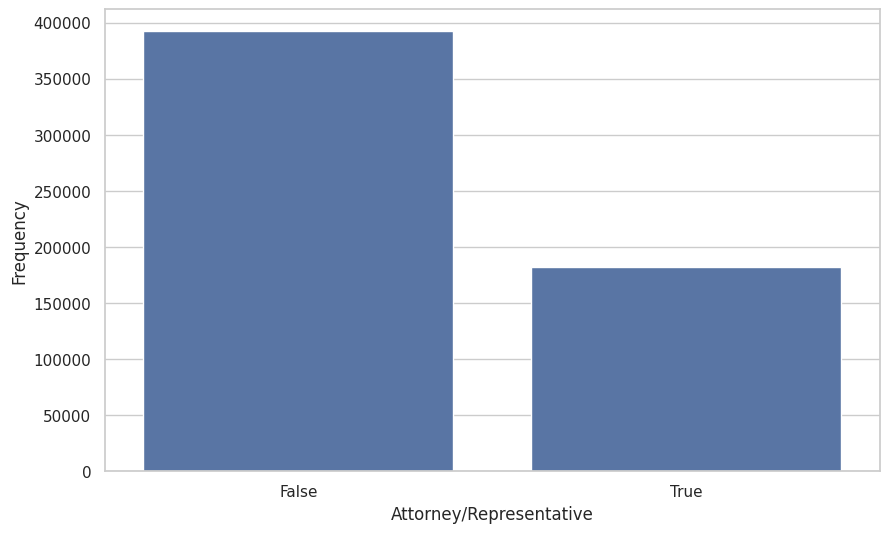

In [226]:
plot_bar(df_train, 'Attorney/Representative')

### Alternative Dispute Resolution variable

In [186]:
df_train['Alternative Dispute Resolution'].value_counts()

,count
Alternative Dispute Resolution,
False,571412
True,2609


The 5 cases recorded with 'U' should be an error. They are likely meant to be 'Y', since the Y and U keys are located next to each other. In fact, the 'Alternative Dispute Resolution' variable should be a boolean. Since 5 cases represent a minority in the data and contain errors, we can safely remove these rows.

In [188]:
df_train = df_train.drop(df_train[df_train['Alternative Dispute Resolution'] == 'U'].index)
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_train['Alternative Dispute Resolution'] = df_train['Alternative Dispute Resolution'].astype("boolean")

In [187]:
df_test= df_test.drop(df_test[df_test['Alternative Dispute Resolution'] == 'U'].index)
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})
df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].astype("boolean")

<ipython-input-187-c25953457653>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Alternative Dispute Resolution'] = df_test['Alternative Dispute Resolution'].replace({'Y': True, 'N': False})


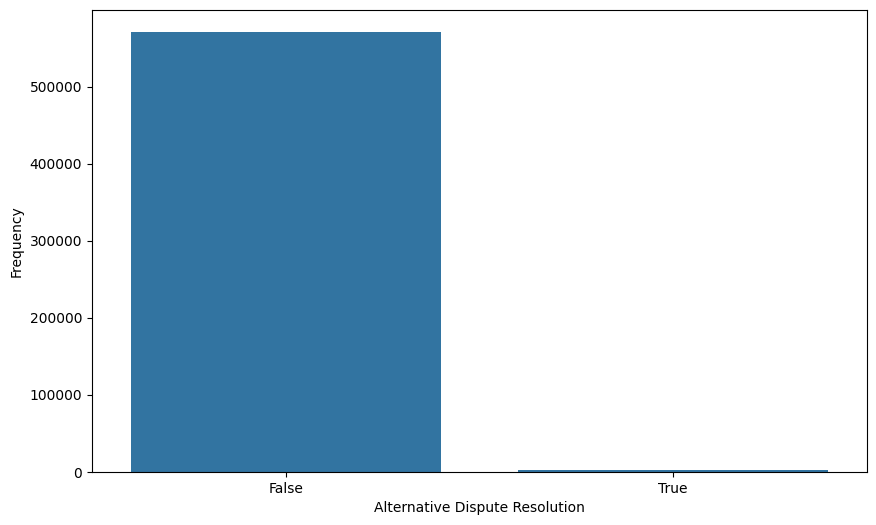

In [184]:
plot_bar(df_train, 'Alternative Dispute Resolution')

### Carrier Name variable

In [190]:
df_train['Carrier Name'].describe()

,Carrier Name
count,574021
unique,2046
top,STATE INSURANCE FUND
freq,111144


In [192]:
df_train['Carrier Name'].isna().sum()

19445

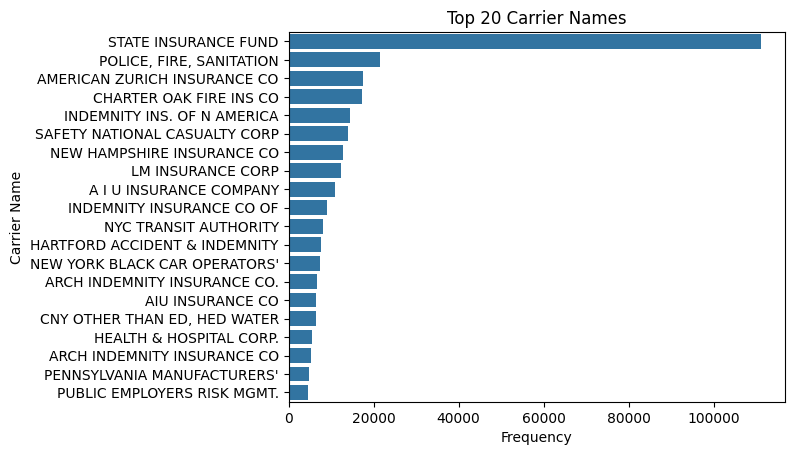

In [194]:
top_carriers = df_train['Carrier Name'].value_counts().nlargest(20)
sns.barplot(x=top_carriers.values, y=top_carriers.index)
plt.title('Top 20 Carrier Names')
plt.xlabel('Frequency')
plt.ylabel('Carrier Name')
plt.show()

### Claim Identifier variable

In [195]:
df_train['Claim Identifier'].describe()

,Claim Identifier
count,5.934660e+05
mean,2.366775e+07
std,1.079276e+08
min,5.393066e+06
25%,5.593414e+06
50%,5.791210e+06
75%,5.990995e+06
max,9.998917e+08


In [197]:
df_train['Claim Identifier'].nunique()

593465

In [200]:
df_train['Claim Identifier'].size

593466

In [198]:
df_train['Claim Identifier'].isna().sum()

0

### District Name variable

In [204]:
df_train['District Name'] = df_train['District Name'].astype('category')
df_test['District Name'] = df_test['District Name'].astype('category')

In [205]:
df_train['District Name'].describe()

,District Name
count,574021
unique,8
top,NYC
freq,270776


In [207]:
df_train['District Name'].isna().sum()

19445

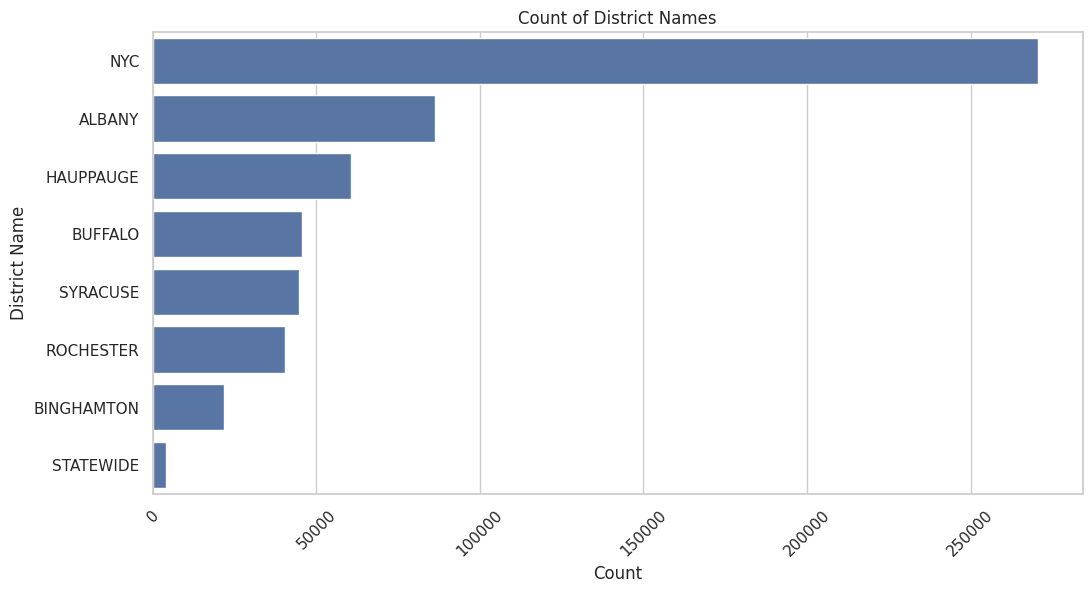

In [210]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a count plot for 'District Name'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='District Name', order=df_train['District Name'].value_counts().index)
plt.title('Count of District Names')
plt.xlabel('Count')
plt.ylabel('District Name')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

### IME-4 Count variable

In [227]:
df_train['IME-4 Count'].describe()

,IME-4 Count
count,132802.000000
mean,3.207354
std,2.832308
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,73.000000


In [228]:
(df_train['IME-4 Count'].isna().mean())*100

77.62264392568403

With ~78% of the IME-4 Count column values missing maybe does not make sense to retain the column in our analysis.


But let's analyse it anyway


Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.

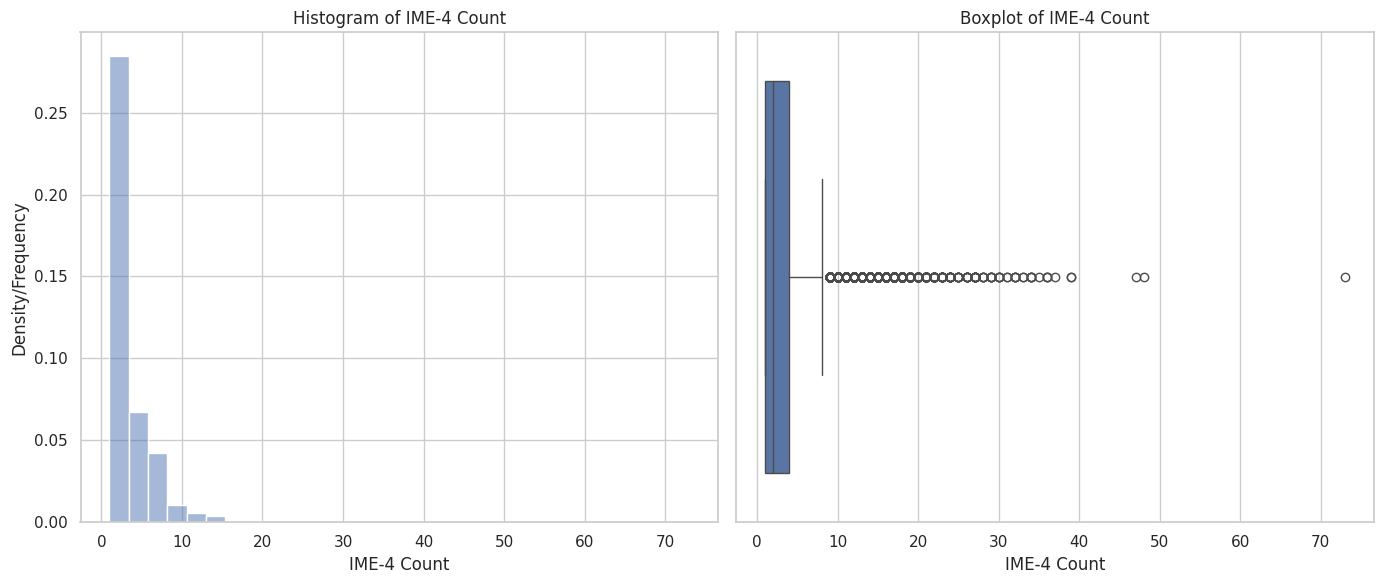

In [213]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Create a histogram for 'IME-4 Count'
sns.histplot(df_train['IME-4 Count'], bins=30, ax=axs[0], stat='density', alpha=0.5)
axs[0].set_title('Histogram of IME-4 Count')
axs[0].set_xlabel('IME-4 Count')
axs[0].set_ylabel('Density/Frequency')

# Create a boxplot for 'IME-4 Count'
sns.boxplot(x=df_train['IME-4 Count'], ax=axs[1],)
axs[1].set_title('Boxplot of IME-4 Count')
axs[1].set_xlabel('IME-4 Count')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Having more than 10 filled IME-4 forms per claim does raise some concerns and could indicate potential errors or unusual circumstances.

In [215]:
df_train[df_train['IME-4 Count'] > 10]['IME-4 Count'].count()

3794

In [218]:
high_submission_claims = df_train[df_train['IME-4 Count'] > 10]
high_submission_claims.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
269,2019-12-22,22.0,False,2020-01-02,Y,443.40,1997.0,2020-01-02,NaT,AMERICAN ZURICH INSURANCE CO,...,74.0,"FELLOW WORKER, PATIENT OR OTHER PERSON",16.0,DISLOCATION,53.0,KNEE,11210,1.0,Not Work Related,2.0
441,2019-12-10,49.0,False,2020-01-02,Y,909.39,1970.0,2020-05-29,2019-12-23,EVEREST NATIONAL INSURANCE CO.,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS (INCLUDING BODY,11208,0.0,Not Work Related,1.0
452,2019-12-20,50.0,False,2020-01-02,Y,1383.50,0.0,2020-01-02,NaT,MANUFACTURERS ALLIANCE,...,56.0,LIFTING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,12419,1.0,Not Work Related,0.0
460,2019-12-31,56.0,False,2020-01-02,Y,900.20,1964.0,2020-01-02,NaT,STATE INSURANCE FUND,...,29.0,ON SAME LEVEL,28.0,FRACTURE,55.0,ANKLE,12458,0.0,Not Work Related,1.0
741,2019-12-20,39.0,False,2020-01-03,Y,756.78,1980.0,2020-01-03,2020-01-24,HARTFORD ACCIDENT & INDEMNITY,...,45.0,COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,10460,0.0,Not Work Related,3.0


Appears that:


*   Alternative Dispute Resolution: The mayjor of the claims have a value of False for the Alternative Dispute Resolution field. This indicates that none of these claims have utilized any alternative methods to resolve the disputes. This might suggest a tendency towards litigation or other formal processes rather than reaching settlements or agreements outside the courtroom.
*   Attorney Representation: The mayjor of the claims have True in the Attorney/Representative field, indicating that all individuals involved in these cases have legal representation. This may suggest that the complexity or severity of these cases warranted the involvement of attorneys.


In [231]:
adr_counts = high_submission_claims['Alternative Dispute Resolution'].value_counts().rename_axis('ADR').reset_index(name='ADR Count')

attorney_counts = high_submission_claims['Attorney/Representative'].value_counts().rename_axis('Attorney').reset_index(name='Attorney Count')

result_df = pd.merge(adr_counts, attorney_counts, left_on='ADR', right_on='Attorney', how='outer')

result_df

,ADR,ADR Count,Attorney,Attorney Count
0,False,3794,NaN,NaN
1,NaN,<NA>,N,22.0
2,NaN,<NA>,Y,3772.0




*   The absence of ADR in the majority of cases coupled with the high percentage of cases with attorney representation suggests that these cases may involve intricate legal matters that require formal adjudication rather than informal resolution methods.
*   This could indicate a trend where claimants opt for legal counsel to ensure their interests are adequately represented, especially when they perceive the claims to be more complicated or when the potential outcomes carry significant implications.
*   The overall situation might reflect a judicial landscape where claimants feel the need to prepare thoroughly for potential litigation rather than resolving disputes outside the courtroom.
*   In conclusion, while the numbers don't necessarily indicate errors, they do highlight a pattern of complexity in the cases being analyzed, warranting further investigation into the nature and outcomes of these claims.





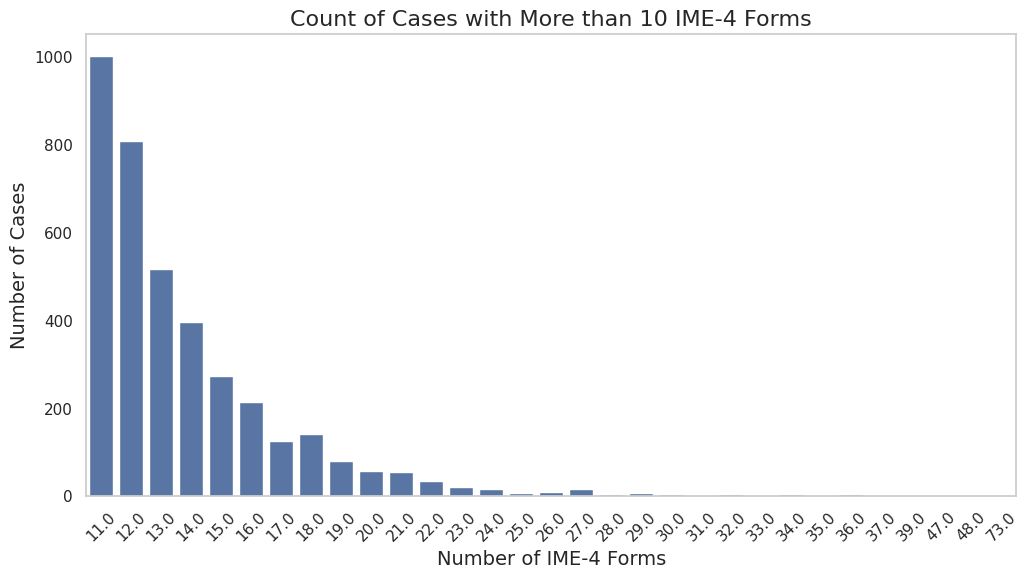

In [232]:
# Filter only the cases with more than 10 IME-4 forms
high_ime4_cases = df_train[df_train['IME-4 Count'] > 10]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=high_ime4_cases, x='IME-4 Count')

# Set up the plot labels
plt.title('Count of Cases with More than 10 IME-4 Forms', fontsize=16)
plt.xlabel('Number of IME-4 Forms', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

### Number of Dependents variable

In [233]:
df_train['Number of Dependents'].describe()

,Number of Dependents
count,574021.000000
mean,3.006549
std,2.000797
min,0.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,6.000000


In [236]:
(df_train['Number of Dependents'].isna().mean())*100

3.2765145770777098

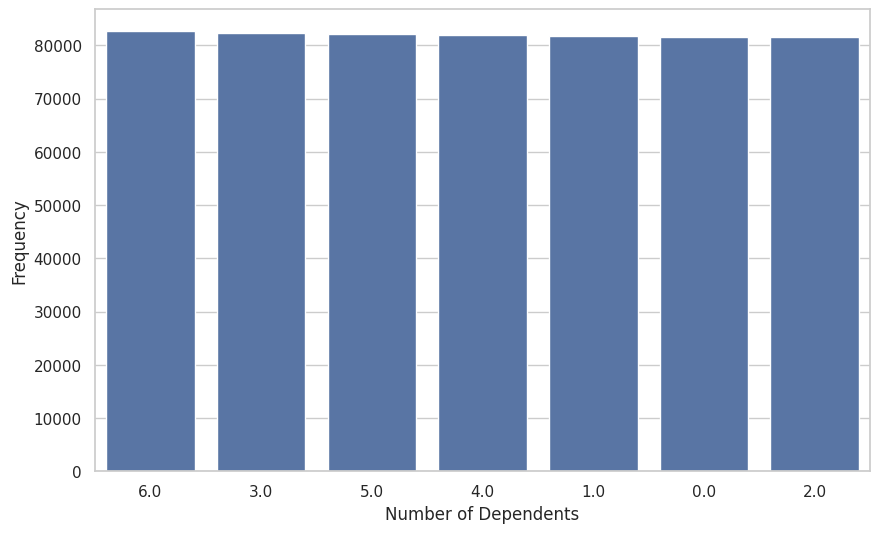

In [237]:
plot_bar(df_train, 'Number of Dependents')

### COVID-19 Indicator

In [239]:
df_train['COVID-19 Indicator'].describe()

,COVID-19 Indicator
count,574021
unique,2
top,N
freq,546500


In [241]:
df_train['COVID-19 Indicator'].value_counts()

,count
COVID-19 Indicator,
N,546500
Y,27521


In [240]:
df_train['COVID-19 Indicator'].isna().sum()

19445

In [244]:
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].astype("boolean")

df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})

# Now convert to nullable boolean type
df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].astype("boolean")

<ipython-input-244-46c2de5b6eeb>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['COVID-19 Indicator'] = df_test['COVID-19 Indicator'].replace({'Y': True, 'N': False})


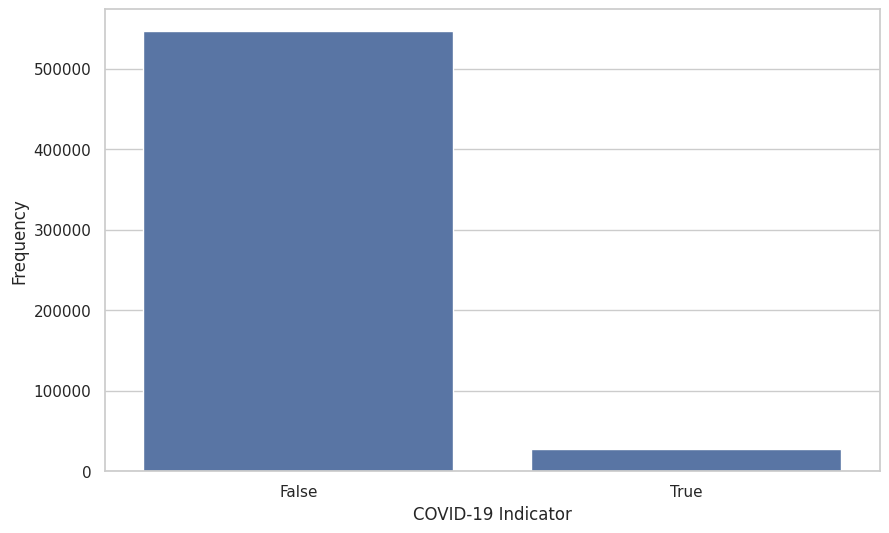

In [245]:
plot_bar(df_train, 'COVID-19 Indicator')

### Average Weekly Wage variable

In [246]:
df_train['Average Weekly Wage'].describe()

,Average Weekly Wage
count,5.453710e+05
mean,4.910919e+02
std,6.092940e+03
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.410000e+02
max,2.828079e+06


In [248]:
(df_train['Average Weekly Wage'] == 0).sum()

335446

It is not possible to have values in 'Average Weekly Wage' recorded as zero since we are talking about workers. Since there are 333933 values recorded as zero, it is very unlikely that this is an error. We should replace the zeros with NaN values.

In [252]:
df_train['Average Weekly Wage'] = df_train['Average Weekly Wage'].replace(0, np.nan)

In [253]:
(df_train['Average Weekly Wage'].isna().mean())*100


64.62729120118085

More than 60% of the Average Weekly Wage column has unknown information. This gonna produce issues in analysis and modeling. Replacing those missing values with statistical measures like the mean or median can skew results and introduce bias, especially if the data is not missing at random. Using methods like KNN can also lead to unreliable estimates if the underlying distribution is not well understood.


Given these circumstances, removing the column might be the most prudent approach.


Let's explore the variable anyway

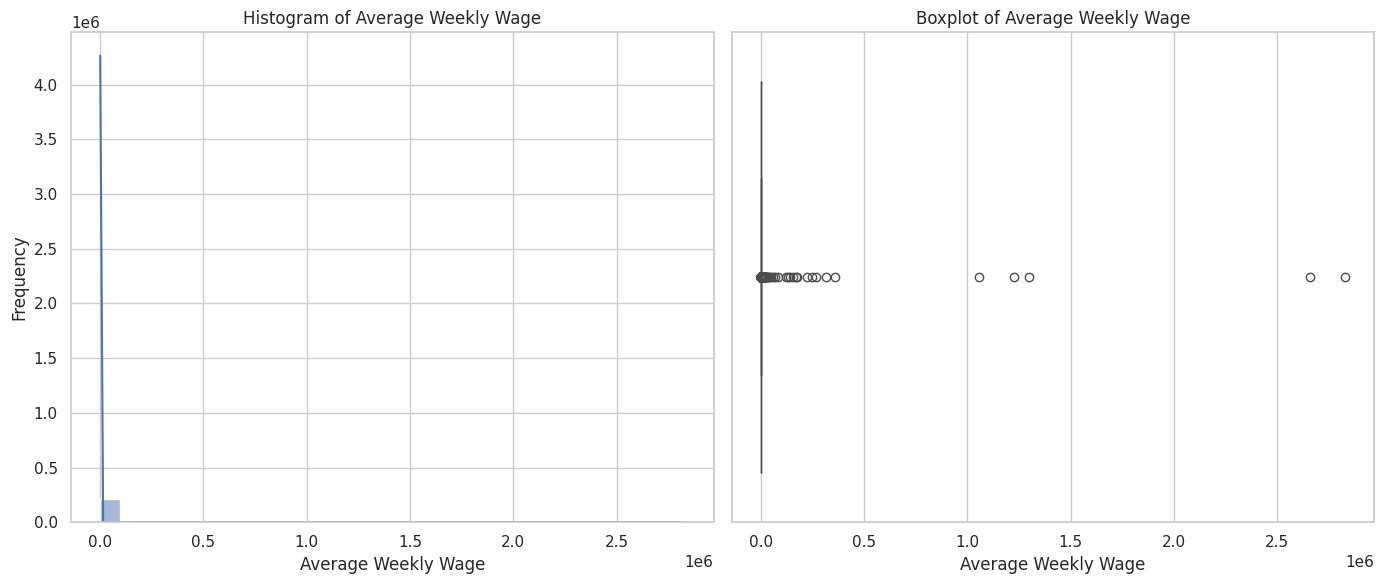

In [255]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_train['Average Weekly Wage'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Histogram of Average Weekly Wage')
axs[0].set_xlabel('Average Weekly Wage')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=df_train['Average Weekly Wage'], ax=axs[1])
axs[1].set_title('Boxplot of Average Weekly Wage')
axs[1].set_xlabel('Average Weekly Wage')

plt.tight_layout()
plt.show()

In [170]:
# For each column
    # Descriptive stats
    # Visualization (Bar, hist, boxplot, .., whatever makes sense)
        # Use above helper function
    # Problems (missing values, invalid values etc.)
        # show examples etc.
    # how to deal with the problems
        # remove rows? replace with null? what happens to null values (replace with median, knN, mode etc)?
        # analyse and find solution with train -> apply solution to train and test

In [171]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

In [172]:
# Daniel:
"""
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64
 3   Assembly Date                       593471 non-null  datetime64[ns]
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 16  First Hearing Date                  150798 non-null  datetime64[ns]
 2   Alternative Dispute Resolution      574026 non-null  object
 4   Attorney/Representative             574026 non-null  object
 10  Carrier Type                        574026 non-null  object
 13  County of Injury                    574026 non-null  object
 """

'\n 0   Accident Date                       570337 non-null  datetime64[ns]\n 1   Age at Injury                       574026 non-null  float64    \n 3   Assembly Date                       593471 non-null  datetime64[ns]\n 6   Birth Year                          544948 non-null  float64    \n 7   C-2 Date                            559466 non-null  datetime64[ns] \n 8   C-3 Date                            187245 non-null  datetime64[ns]\n 16  First Hearing Date                  150798 non-null  datetime64[ns]\n 2   Alternative Dispute Resolution      574026 non-null  object    \n 4   Attorney/Representative             574026 non-null  object       \n 10  Carrier Type                        574026 non-null  object        \n 13  County of Injury                    574026 non-null  object         \n '

In [173]:
# Louis:
"""
 19  Industry Code                       564068 non-null  float64
 20  Industry Code Description           564068 non-null  object
 21  Medical Fee Region                  574026 non-null  object
 23  WCIO Cause of Injury Code           558386 non-null  float64
 24  WCIO Cause of Injury Description    558386 non-null  object
 25  WCIO Nature of Injury Code          558369 non-null  float64
 26  WCIO Nature of Injury Description   558369 non-null  object
 27  WCIO Part Of Body Code              556944 non-null  float64
 28  WCIO Part Of Body Description       556944 non-null  object
 29  Zip Code                            545389 non-null  object
 12  Claim Injury Type                   574026 non-null  object
 17  Gender                              574026 non-null  object
"""

'\n 19  Industry Code                       564068 non-null  float64       \n 20  Industry Code Description           564068 non-null  object        \n 21  Medical Fee Region                  574026 non-null  object     \n 23  WCIO Cause of Injury Code           558386 non-null  float64       \n 24  WCIO Cause of Injury Description    558386 non-null  object        \n 25  WCIO Nature of Injury Code          558369 non-null  float64       \n 26  WCIO Nature of Injury Description   558369 non-null  object        \n 27  WCIO Part Of Body Code              556944 non-null  float64       \n 28  WCIO Part Of Body Description       556944 non-null  object        \n 29  Zip Code                            545389 non-null  object \n 12  Claim Injury Type                   574026 non-null  object\n 17  Gender                              574026 non-null  object        \n'

In [174]:
# Rita:
"""
 5   Average Weekly Wage                 545375 non-null  float64
 9   Carrier Name                        574026 non-null  object
 11  Claim Identifier                    593471 non-null  int64
 14  COVID-19 Indicator                  574026 non-null  object
 15  District Name                       574026 non-null  object
 18  IME-4 Count                         132803 non-null  float64
 22  Number of Dependents                574026 non-null  float64
"""

'\n 5   Average Weekly Wage                 545375 non-null  float64       \n 9   Carrier Name                        574026 non-null  object        \n 11  Claim Identifier                    593471 non-null  int64         \n 14  COVID-19 Indicator                  574026 non-null  object        \n 15  District Name                       574026 non-null  object        \n 18  IME-4 Count                         132803 non-null  float64       \n 22  Number of Dependents                574026 non-null  float64       \n'

## Step 3: Cross-Feature analysis

In [175]:
# cross-feature inconsistencies
    # all dates have to be after incident date
    # if covid code -> covid has to be true
    # code vs description (just check, we will ignore the descriptions later)
    # How to deal with inconsistencies
# cross-feature visualisations
    # Write down Visualisation insights

# Re-Run of Exploratory Analysis